In [ ]:
import argparse
import os
import random
import json
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torchshow as ts
from timechat.common.config import Config
from timechat.common.dist_utils import get_rank
from timechat.common.registry import registry
from timechat.conversation.conversation_video import Chat, Conversation, default_conversation,SeparatorStyle, conv_llava_llama_2
import decord
import cv2
import time
import subprocess
from decord import VideoReader
from timechat.processors.video_processor import ToTHWC, ToUint8, load_video
decord.bridge.set_bridge('torch')

# imports modules for registration
from timechat.datasets.builders import *
from timechat.models import *
from timechat.processors import *
from timechat.runners import *
from timechat.tasks import *

import random as rnd
from transformers import StoppingCriteria, StoppingCriteriaList
from PIL import Image
import gradio as gr

In [ ]:
def parse_args():
    parser = argparse.ArgumentParser(description="Demo")
    parser.add_argument("--cfg-path", default='eval_configs/timechat.yaml', help="path to configuration file.")
    parser.add_argument("--gpu-id", type=int, default=0, help="specify the gpu to load the model.")
    parser.add_argument("--num-beams", type=int, default=1)
    parser.add_argument("--temperature", type=float, default=1.0)
    parser.add_argument("--text-query", default="What is he doing?", help="question the video")
    parser.add_argument("--video-path", default='examples/hotdog.mp4', help="path to video file.")
    parser.add_argument(
        "--options",
        nargs="+",
        help="override some settings in the used config, the key-value pair "
        "in xxx=yyy format will be merged into config file (deprecate), "
        "change to --cfg-options instead.",
    )
    args = parser.parse_args(args=[])
    return args

In [121]:
print('Initializing Chat')
args = parse_args()
cfg = Config(args)

DIR="ckpt/timechat"
MODEL_DIR=f"{DIR}/timechat_7b.pth"

model_config = cfg.model_cfg
model_config.device_8bit = args.gpu_id
model_config.ckpt = MODEL_DIR
model_cls = registry.get_model_class(model_config.arch)
model = model_cls.from_config(model_config).to('cuda:{}'.format(args.gpu_id))
model.eval()

vis_processor_cfg = cfg.datasets_cfg.webvid.vis_processor.train
vis_processor = registry.get_processor_class(vis_processor_cfg.name).from_config(vis_processor_cfg)

Initializing Chat
Loading VIT


INFO:root:freeze vision encoder


Loading VIT Done
Loading Q-Former
use text input for Qformer


INFO:root:load checkpoint from ckpt/instruct-blip/instruct_blip_vicuna7b_trimmed.pth
INFO:root:freeze Qformer
INFO:root:Loading Q-Former Done
INFO:root:Loading LLAMA Tokenizer
Using pad_token, but it is not set yet.
INFO:root:Loading LLAMA Model
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.61s/it]
INFO:root:use gradient checkpointing for LLAMA
INFO:root:Loading LLAMA Done
INFO:root:Using LORA


KeyboardInterrupt: 

In [ ]:
chat = Chat(model, vis_processor, device='cuda:{}'.format(args.gpu_id))
print('Initialization Finished')

Initialization Finished


torch.Size([3, 96, 480, 640])


'The video contains 96 frames sampled at 0.0, 0.0, 0.1, 0.1, 0.2, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.7, 0.8, 0.8, 0.9, 0.9, 0.9, 1.0, 1.0, 1.1, 1.1, 1.2, 1.2, 1.2, 1.3, 1.3, 1.4, 1.4, 1.4, 1.5, 1.5, 1.6, 1.6, 1.7, 1.7, 1.7, 1.8, 1.8, 1.9, 1.9, 1.9, 2.0, 2.0, 2.1, 2.1, 2.2, 2.2, 2.2, 2.3, 2.3, 2.4, 2.4, 2.4, 2.5, 2.5, 2.6, 2.6, 2.7, 2.7, 2.7, 2.8, 2.8, 2.9, 2.9, 2.9, 3.0, 3.0, 3.1, 3.1, 3.2, 3.2, 3.2, 3.3, 3.3, 3.4, 3.4, 3.4, 3.5, 3.5, 3.6, 3.6, 3.7, 3.7, 3.7, 3.8, 3.8, 3.9, 3.9, 3.9 seconds. '

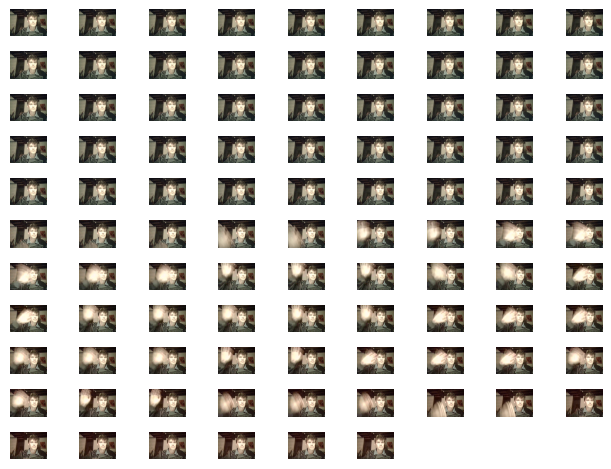

In [128]:
NUM_FRAMES = 96
SAMPLING = "uniform" # "headtail"
args.video_path = "examples/short.mp4"

video, msg = load_video(
    video_path=args.video_path,
    n_frms=NUM_FRAMES,
    sampling =SAMPLING, return_msg = True
)
# video = vis_processor.transform(video)
print(video.size())
C, T, H, W = video.shape
ts.show(video.transpose(0, 1))

msg

In [129]:
img_list = []
chat_state = conv_llava_llama_2.copy()
chat_state.system =  "You are able to understand the visual content that the user provides. Follow the instructions carefully and explain your answers in detail."
msg = chat.upload_video_without_audio(
    video_path=args.video_path, 
    conv=chat_state,
    img_list=img_list, 
    n_frms=NUM_FRAMES,
    sampling=SAMPLING,
)

msg, chat_state

('Received.',
 Conversation(system='You are able to understand the visual content that the user provides. Follow the instructions carefully and explain your answers in detail.', roles=('USER', 'ASSISTANT'), messages=[['USER', '<Video><ImageHere></Video> The video contains 96 frames sampled at 0.0, 0.0, 0.1, 0.1, 0.2, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.7, 0.8, 0.8, 0.9, 0.9, 0.9, 1.0, 1.0, 1.1, 1.1, 1.2, 1.2, 1.2, 1.3, 1.3, 1.4, 1.4, 1.4, 1.5, 1.5, 1.6, 1.6, 1.7, 1.7, 1.7, 1.8, 1.8, 1.9, 1.9, 1.9, 2.0, 2.0, 2.1, 2.1, 2.2, 2.2, 2.2, 2.3, 2.3, 2.4, 2.4, 2.4, 2.5, 2.5, 2.6, 2.6, 2.7, 2.7, 2.7, 2.8, 2.8, 2.9, 2.9, 2.9, 3.0, 3.0, 3.1, 3.1, 3.2, 3.2, 3.2, 3.3, 3.3, 3.4, 3.4, 3.4, 3.5, 3.5, 3.6, 3.6, 3.7, 3.7, 3.7, 3.8, 3.8, 3.9, 3.9, 3.9 seconds. ']], offset=0, sep_style=<SeparatorStyle.LLAMA_2: 3>, sep='<s>', sep2='</s>', skip_next=False, conv_id=None))

**The chat_state keeps adding questions!!**

In [140]:
def single_query(text_input, system=None):
    img_list = []
    chat_state = conv_llava_llama_2.copy()
    if not system:
        chat_state.system =  "You are able to understand the visual content that the user provides. Follow the instructions carefully and explain your answers in detail."
    else:
        chat_state.system = system
    msg = chat.upload_video_without_audio(
        video_path=args.video_path, 
        conv=chat_state,
        img_list=img_list, 
        n_frms=NUM_FRAMES,
        sampling=SAMPLING,
    )
    
    print(text_input)

    chat.ask(text_input, chat_state)

    num_beams = args.num_beams
    temperature = args.temperature
    llm_message = chat.answer(conv=chat_state,
                            img_list=img_list,
                            num_beams=num_beams,
                            temperature=temperature,
                            max_new_tokens=300,
                            max_length=2000)[0]

    print(llm_message)

In [139]:
single_query(
    "Describe the short video fragment."
)

Describe the short video fragment.
In the video, a man is talking and showing his hand.


In [149]:
single_query(
    "What do you see?",
    system="You are a sentient camera."
)

What do you see?
I see a man sitting in front of a camera, looking at it.


In [150]:
single_query(
    "How long is the video?"
)

How long is the video?
The video is 5.0 seconds long.


In [160]:
single_query(
    "At 2.0 seconds, the man starts waving. What do you see after that?",
    #system="You are a sentient camera."
)

At 2.0 seconds, the man starts waving. What do you see after that?
A person in a black sweater moves his hand across the screen.


'Here is the description of the video:\nFrame at 0.0 second: a man is shown.\nFrame at 1.9 second: the man starts waving.\nWhat happens between 2.0 - 4.0 seconds?'

In [182]:
single_query(
    """Here is the description of the video:
Frame at 0.0 second: a man is shown.
Frame at 1.9 second: the man starts waving.
What do you see after that?""",
    #system="You are a sentient camera."
)

Here is the description of the video:
Frame at 0.0 second: a man is shown.
Frame at 1.9 second: the man starts waving.
What do you see after that?
A young man sitting and waving his hands around.


In [133]:
single_query(
    "Previously,\n\nthe man was walking around.\n\nWhat is happening now?"
)

Previously,

the man was walking around.

What is happening now?
A man in a patterned sweater gets up close and then throws up his hand at the camera.


In [134]:
single_query(
    "Previously, the man was walking around. What is happening now?"
)

Previously, the man was walking around. What is happening now?
The man waves his hands in front of the camera.


In [135]:
text_input = "Generate a summarized version of the video, focusing on extracting key frames that best represent the overall narrative. The output should be a list of timestamps in seconds and their corresponding salient scores."

single_query(text_input)

Generate a summarized version of the video, focusing on extracting key frames that best represent the overall narrative. The output should be a list of timestamps in seconds and their corresponding salient scores.
The highlight frames are in 10 - 15 seconds.


In [136]:
single_query(
    "Describe the people in the video in as much detail as possible."
)

Describe the people in the video in as much detail as possible.
The people in the video include a young man, a person who is sitting, a guy, a man wearing a cardigan, and a young man with a goatee. They are all shown in different scenarios and environments, such as a dark room, a room, a house, and a person talking on a camera. Some of them are seen in close-up, while others are shown from a distance. The video also includes the sound of clapping.


In [137]:
single_query(
    "What happens in the last frame?"
)

What happens in the last frame?
The camera zooms out.
